In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import numpy as np
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm_notebook as tqdm
from tensorflow.contrib import slim

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28*28).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28*28).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [4]:
# graph = tf.Graph()
sess = tf.InteractiveSession()

In [5]:
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

In [6]:
input_dataset = tf.placeholder(dtype=tf.float32, shape=[None, 28*28], name='input_dataset')

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(input_dataset)

In [8]:
data_iterator = dataset.shuffle(len(train_images)).batch(32).repeat().make_initializable_iterator()

In [9]:
input_img = data_iterator.get_next()

In [10]:
input_img

<tf.Tensor 'IteratorGetNext:0' shape=(?, 784) dtype=float32>

In [186]:
def encoder(x):
    with tf.variable_scope('encoder'):
        x = slim.fully_connected(x, 256, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 128, activation_fn=tf.nn.relu)
        mu = slim.fully_connected(x, 32, activation_fn=None)
        sigma = slim.fully_connected(x, 32, activation_fn=tf.nn.softplus)
        return mu, sigma
    
    
def decoder(x):
    with tf.variable_scope('decoder'):
        x = slim.fully_connected(x, 128, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 256, activation_fn=tf.nn.relu)
        x = slim.fully_connected(x, 28*28, activation_fn=None)
        return x
    
    
class VAE:
    
    def __init__(self, x):
        with tf.variable_scope('vae', reuse=tf.AUTO_REUSE):
            self.x = x
            self.mu, self.sigma = encoder(x)
            self.q_z = tf.distributions.Normal(self.mu, self.sigma)
            self.q_z_sample = self.q_z.sample()
            
            self.p_z = tf.distributions.Normal(0.0, 1.0)
            
            self.x_z = decoder(self.q_z_sample)
            self.x_z_distribution = tf.distributions.Bernoulli(logits=self.x_z)
            self.x_z_sample = self.x_z_distribution.sample()
            self._loss = None
        
    
    @property
    def loss(self):
        if self._loss is None:
            self.kl = tf.reduce_sum(tf.distributions.kl_divergence(self.p_z, self.q_z), axis=1)
            self.log_likelihood = tf.reduce_sum(self.x_z_distribution.log_prob(self.x), axis=1)
            elbo = tf.reduce_mean(self.log_likelihood - self.kl)
            self._loss = -elbo
        return self._loss
    
        

In [187]:
vae = VAE(input_img)

In [34]:
vae.loss

<tf.Tensor 'Neg_1:0' shape=() dtype=float32>

In [189]:
with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(vae.loss)

In [190]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [184]:
sess.run(data_iterator.initializer, feed_dict={input_dataset: train_images}) 

In [141]:
from IPython import display

In [230]:
epochs = 10
for epoch in range(1, epochs + 1):
    start_time = time.time()
    all_elbos = []
    all_kl = []
    all_logl = []
    cnt = 0
    try:
        for i in tqdm(range(60000/32)):
            _, elbo_value, kl, logl = sess.run([train_op, vae.loss, vae.kl, vae.log_likelihood])
            all_elbos.append(elbo_value)
            all_kl.append(kl)
            all_logl.append(logl)
            cnt +=1
    except tf.errors.OutOfRangeError:
        pass
        
    end_time = time.time()

#     display.clear_output(wait=False)
    print('Epoch: {}, ELBO: {},  KL: {}, LogLikelihood: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    np.mean(all_elbos), np.mean(all_kl), np.mean(all_logl),
                                                    end_time - start_time))
    
    all_elbos = []


Epoch: 1, ELBO: 112.179649353,  KL: 23.8750839233, LogLikelihood: -88.3045654297, time elapse for current epoch 8.40512681007



Epoch: 2, ELBO: 111.883682251,  KL: 23.9397850037, LogLikelihood: -87.943901062, time elapse for current epoch 8.25828814507



Epoch: 3, ELBO: 111.462249756,  KL: 23.985414505, LogLikelihood: -87.4768447876, time elapse for current epoch 8.1561319828



Epoch: 4, ELBO: 111.129638672,  KL: 24.0456180573, LogLikelihood: -87.084022522, time elapse for current epoch 8.24231410027



Epoch: 5, ELBO: 110.817764282,  KL: 24.0775928497, LogLikelihood: -86.7401657104, time elapse for current epoch 8.40943408012



Epoch: 6, ELBO: 110.466506958,  KL: 24.162437439, LogLikelihood: -86.304069519, time elapse for current epoch 8.18759894371



Epoch: 7, ELBO: 109.971946716,  KL: 24.1537895203, LogLikelihood: -85.8181686401, time elapse for current epoch 8.19577503204



Epoch: 8, ELBO: 109.762466431,  KL: 24.1982097626, LogLikelihood: -85.5642700195, time elapse for current epoch 8.65719795227



Epoch: 9, ELBO: 109.538360596,  KL: 24.2899570465, LogLikelihood: -85.2483978271, time elapse for current epoch 8.55536079407



Epoch: 10, ELBO: 109.177314758,  KL: 24.2820701599, LogLikelihood: -84.8952484131, time elapse for current epoch 8.09539699554


In [192]:
test_img = tf.placeholder(dtype=np.float32, shape=(1,28*28))

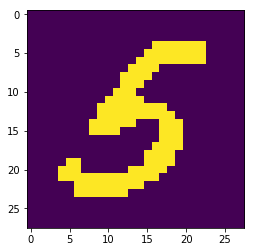

In [252]:
import random

img = train_images[random.randint(0,1000)].reshape(28,28)
plt.imshow(img)

In [216]:
test_vae = VAE(test_img)

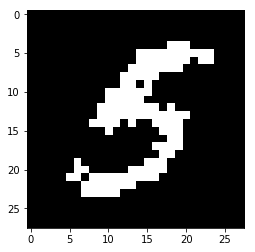

In [264]:
img_res, mu, sigma = sess.run([test_vae.x_z_sample, test_vae.mu, test_vae.sigma], feed_dict={test_vae.x: img.reshape(1,28*28)})
plt.imshow(img_res.reshape(28,28), cmap='gray')

In [229]:
mu, sigma

(array([[ 0.78609943,  1.7558758 ,  0.37973988,  0.5070829 , -0.97787666,
         -1.8062366 ,  1.1249653 ,  2.677858  , -0.3819904 ,  0.29011795,
          0.4162508 , -2.370855  , -0.05751862,  3.4252708 ,  0.15634331,
          0.0208275 , -0.8918959 , -4.020893  , -1.3652205 , -4.7685957 ,
          1.9510143 , -1.4137087 , -0.7249669 ,  0.40732515, -3.288084  ,
         -0.04110166, -0.5242153 , -0.3531016 , -1.2537318 , -0.31856614,
          1.7966882 ,  1.8285857 ]], dtype=float32),
 array([[0.942603  , 1.0250568 , 0.6460827 , 0.9596573 , 0.71117526,
         1.0960556 , 1.2179852 , 1.2276437 , 0.9992308 , 0.8818184 ,
         1.1137724 , 1.566715  , 0.75270337, 1.5106444 , 0.7457081 ,
         0.8866695 , 1.1036036 , 2.0120564 , 0.9510335 , 2.0995111 ,
         1.2229885 , 0.97526824, 0.87093145, 0.9610169 , 1.2657952 ,
         0.8231456 , 1.003576  , 0.875557  , 1.116326  , 1.0703073 ,
         1.0007492 , 1.2643056 ]], dtype=float32))

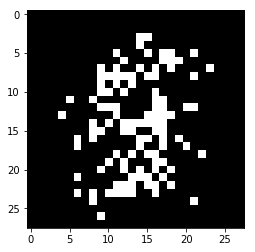

In [174]:
img = sess.run(test_vae.x_z_sample, feed_dict={test_vae.q_z_sample: np.random.randn(1,32)}).reshape((28,28))
plt.imshow(img, cmap='gray')